<h1> Free Inductive Decay Analysis

<h5>
In Nuclear Magnetic Resonance (NMR), the Free Induction Decay (FID) is the time-domain signal detected immediately after applying a radiofrequency (RF) pulse to a sample. When the RF pulse tips the net magnetization of nuclear spins away from the external magnetic field, the spins begin to precess coherently in the transverse plane. As they relax back toward equilibrium, this transverse magnetization induces a decaying oscillating voltage in the detector coil — the FID.
The FID contains all the frequency information about the nuclear environment, but it appears as a damped sinusoidal signal in the time domain. By applying a Fourier Transform, the FID is converted into the frequency-domain spectrum, where chemical shifts, splitting patterns, and relaxation effects can be analyzed.
The decay rate of the FID is determined by the transverse relaxation time (T₂*), which incorporates both intrinsic spin-spin relaxation (T₂) and local magnetic field inhomogeneities. A long T₂* leads to a slower-decaying FID and sharper spectral lines, while a short T₂* produces rapid decay and broader lines.

----

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import scipy.optimize as opt
from scipy.optimize import curve_fit    

In [2]:
###########################
# Setup Plotting Defaults #
###########################
# For more options see https://matplotlib.org/users/customizing.html

# Commands for high detail plots (much larger in file size though)
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.dpi'] = 1000

#Increase display resolution
mpl.rcParams['figure.dpi'] = 200

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
#prevents lines from being jagged
mpl.rcParams['lines.antialiased'] = True

#
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5

#I have no idea what this does
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1

mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
#defines the colors to cycle through when line colors are not specifically defined
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'DejaVu Serif'
mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['text.usetex'] = True

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelpad'] = 9.0

# Title
mpl.rcParams['axes.titlepad'] = 10.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 22

#default in mpl v2.0 is 'out'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['ytick.minor.visible'] = True

#Error bar plots
#default in mpl v2.0 is no caps on error bars
mpl.rcParams['errorbar.capsize'] = 3

# Legend
mpl.rcParams['legend.fontsize'] = 22
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.8
mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation

# Figure size
mpl.rcParams['figure.figsize'] = 12, 8

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1
mpl.rcParams['savefig.dpi'] = 200 #higher-res than default 100 dpi

<h3> Importing data

In [3]:
fid_data = pd.read_csv(
    "./data/raw_data/single_pulse_nmr_fid.txt",
    skiprows=18,           
    sep=',',
    header=None, 
)

fid_data.columns = ['Frequency (kHz)', 'Power spectral density']
fid_data["Frequency (kHz)"] = pd.to_numeric(fid_data["Frequency (kHz)"], errors="coerce")

fid_data.head()


,Frequency (kHz),Power spectral density
0,-1500.0000,27286.3276
1,-1499.8169,62837.6084
2,-1499.6338,34134.5997
3,-1499.4507,29259.1435
4,-1499.2676,15836.6470


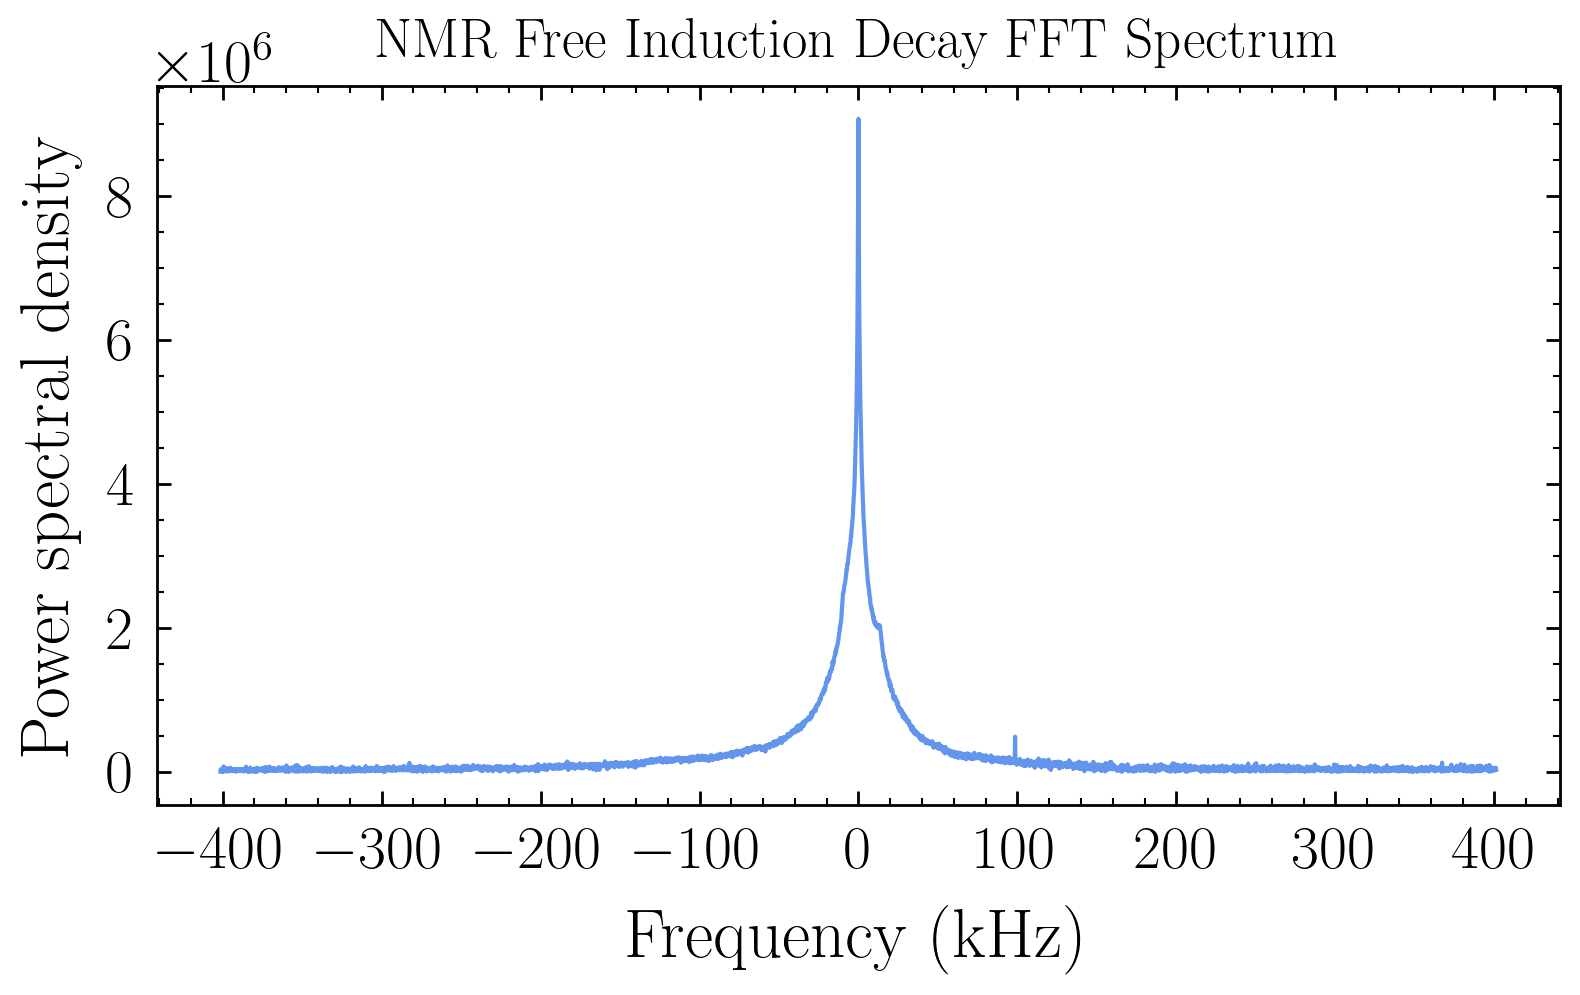

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(fid_data["Frequency (kHz)"][6000:10384], fid_data["Power spectral density"][6000:10384])
plt.xlabel("Frequency (kHz)")
plt.ylabel("Power spectral density")

# Limit number of ticks
plt.locator_params(axis="x", nbins=10) 
plt.locator_params(axis="y", nbins=6)   
plt.tight_layout()
plt.title("NMR Free Induction Decay FFT Spectrum", fontsize=20)
plt.show()


Text(0.5, 1.0, 'NMR Free Induction Decay FFT Spectrum with Lorentzian Fit')

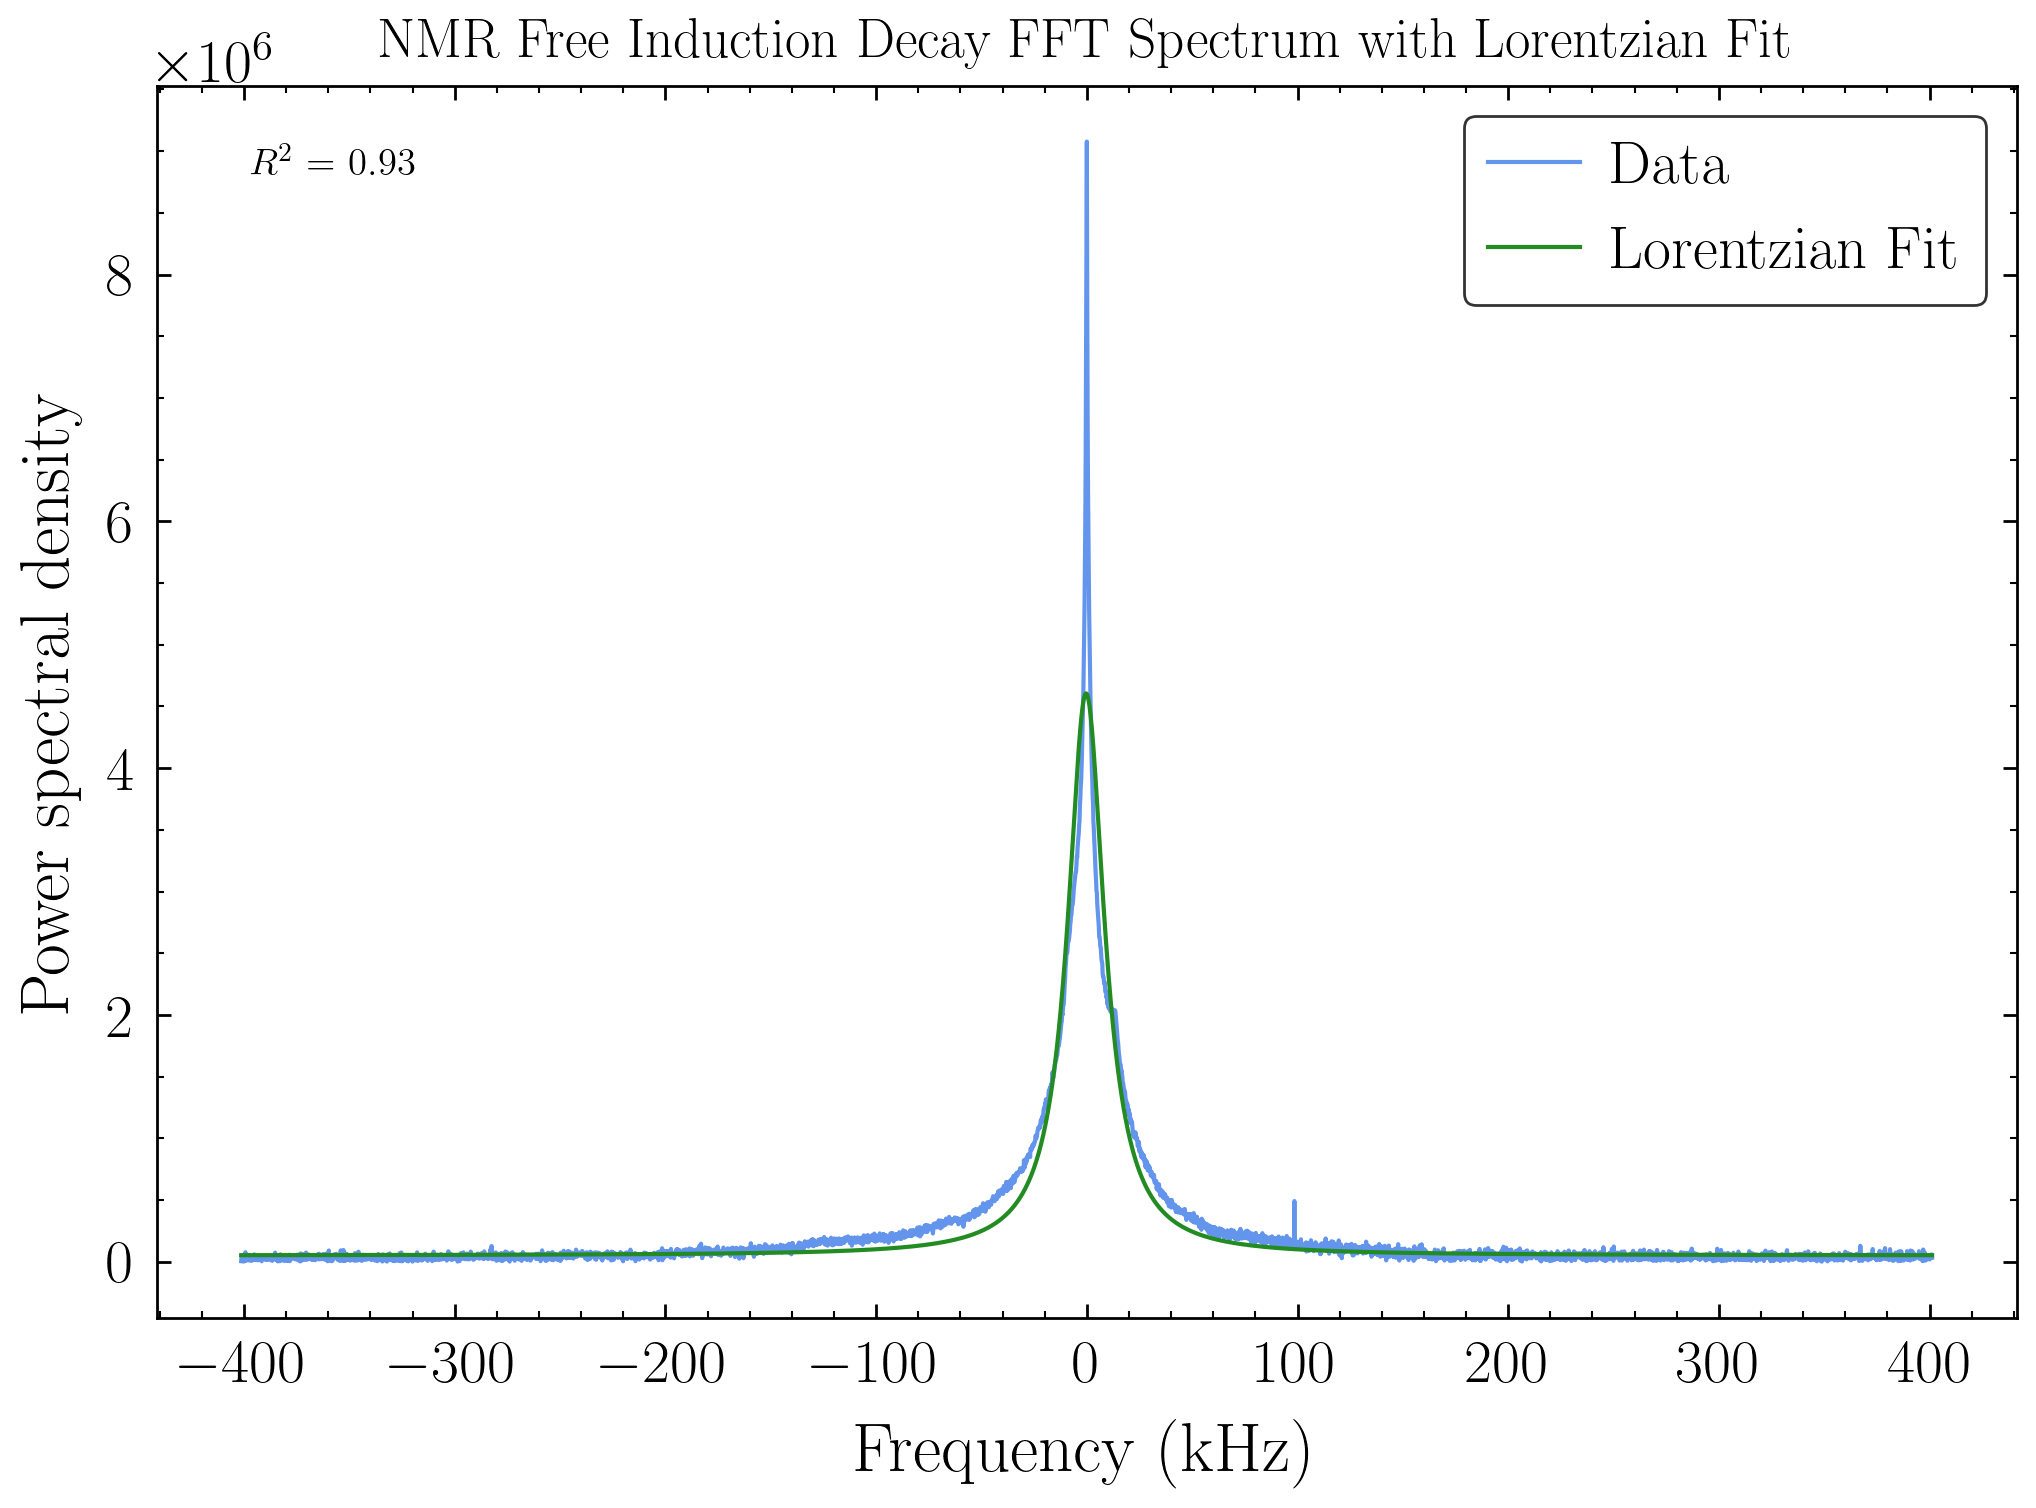

In [26]:
def lorentzian_fit(x, x0, a, gamma, d):
    return a * (gamma**2 / ((x - x0)**2 + gamma**2)) + d

popt, pcov = curve_fit(
    lorentzian_fit,
    fid_data["Frequency (kHz)"],
    fid_data["Power spectral density"],
    p0=[1.4, np.max(fid_data["Power spectral density"]), 0.5, 0],
    maxfev=100000,
)

plt.plot(
    fid_data["Frequency (kHz)"][6000:10384],
    fid_data["Power spectral density"][6000:10384],
    label="Data",
)

plt.plot(
    fid_data["Frequency (kHz)"][6000:10384],
    lorentzian_fit(
        fid_data["Frequency (kHz)"][6000:10384], *popt
    ),
    label="Lorentzian Fit",
)

#calculate r**2
residuals = fid_data["Power spectral density"] - lorentzian_fit(
    fid_data["Frequency (kHz)"], *popt
)
ss_res = np.sum(residuals**2)
ss_tot = np.sum(
    (fid_data["Power spectral density"] - np.mean(fid_data["Power spectral density"]))**2
)
r_squared = 1 - (ss_res / ss_tot)

plt.text(0.05, 0.95, f"$R^2$ = {r_squared:.2f}", transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.legend()

plt.xlabel("Frequency (kHz)")
plt.ylabel("Power spectral density")
plt.title("NMR Free Induction Decay FFT Spectrum with Lorentzian Fit", fontsize=20)